# BOSS Sky Results Compared with other results

This notebook creates plots from other papers to compare results of BOSS dataset to documented results. It also compares published brightness results and converts units so they can all be compared.

In [2]:
%matplotlib inline
import os, sys, glob, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy import interpolate

In [3]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('large')

In [4]:
DATA_DIR = '/Volumes/PFagrelius_Backup/sky_data/'

## Change units

### For Single Wavelengths

$m=-2.5log_{10}(\frac{f_{\nu}}{ZP})$ where ZP is the zero point

$f_{\nu} = 3.34\times10^{4}(\frac{\lambda}{Ang})\frac{f_{\lambda}}{erg/(cm^{2} s Ang)}$

$f_{\lambda} = \frac{ZP}{3.34\times10^{4}}\frac{1}{\lambda^{2}}10^{-0.4\, m}$

In [5]:
#Zero Points in Janskys
AB_z = 3631
U_z = 1810
B_z = 4260
V_z = 3640 
R_z = 3080 
I_z = 2550

In [6]:
#Effective wavelengths for band
Y_nm = 1020
J_nm = 1220
H_nm = 1630
U_nm = 359.62
B_nm = 424.30
V_nm = 545.74
R_nm = 647.49
I_nm = 786.46

In [37]:
def mag_to_flux(mag, wave, zero, per_arcsec2 =False):
    """Calcuates flux in 10**-17 erg/s/cm2/A. If the magnitude is quoted per arcsec^2, 
    the BOSS fiber area of pi arcsec^2 is multiplied.
    """
    w = wave*10 #angstroms
    f_nu = zero*(10**(-0.4*mag)) #Jansky
    f_lam = f_nu/(3.34*10**4)*(w**(-2))
    f_lam = f_lam*10**17 #10^-17 erg/s/cm2/A
    if per_arcsec2:
        f_lam = f_lam * np.pi #10^-17 erg/s/cm2/A
    print("unit: 10^-17/erg/s/cm2/A")
    return f_lam

In [8]:
def flux_to_mag(flux, wave, zero, per_arcsec2 =True):
    """Converts flux in 10^-17 erg/s/cm2/A to mag or mag/arcsec^2
    """
    w = wave*10 #angstrom
    flux = flux*10**(-17)
    if per_arcsec2:
        flux = flux/np.pi
    f_nu = flux * (w**2) * 3.34*10**4
    mag = -2.5*np.log10(f_nu/zero)
    return mag

In [9]:
def mag_to_phot(mag, wave, zero):
    """Converts magnitude/arcsec2 to phot/s/m2/arcsec2/um
    """
    w = wave/1000. #nm -> um
    f_nu = zero*(10**((mag)*(-2/5))) #Jansky/arcsec2
    flux = f_nu/(6.626*10**(-8))*(1/w) #phot/s/m2/um/arcsec2
    return flux

In [10]:
def phot_to_mag(flux, wave, zero):
    """Converts phot/s/m2/arcsec2/um to magnitude/arcsec2
    """
    w = wave/1000. #nm -> um
    f_nu = flux*w*(6.626*10**(-8))
    mag = -2.5*np.log10(f_nu/zero)
    return mag

### For bands

Get filter parameters here: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=Paranal&gname2=FORS1

In [19]:
# Transmission curve names:
Trans_files = {'V': 'ESO1035', 'U':'ESO1033', 'B':'ESO1034', 'R': 'ESO1036', 'I': 'ESO1037'}

In [20]:
def get_Johnson_mean_mag(band, spect, zero):
    # Johnson mags from spectroscopic data
    filen = Trans_files[band]
    Trans = np.loadtxt('/Users/parkerf/Downloads/Paranal_FORS1.%s.dat'%filen)
    T = interpolate.interp1d(Trans[:,0],Trans[:,1])
    new_spectrum = spect[(spect['WAVE']*10.>Trans[0][0])&(spect['WAVE']*10.<Trans[-1][0])]
    new_spectrum['SKY'][new_spectrum['SKY'] == -np.inf] = 0
    new_spectrum['SKY'][new_spectrum['SKY'] == np.inf] = 0
    new_flux = new_spectrum['SKY']*10**(-17)*(new_spectrum['WAVE']*10.)**2.*3.34*10**4./(np.pi)
    flux = np.sum(new_flux*T(new_spectrum['WAVE']*10.),axis=0)

    flux_nu = flux/np.sum(zero*T(new_spectrum['WAVE']*10.), axis=0)
    mag = -2.5*np.log10(flux_nu)
    
    return mag

## Compare published results

In [54]:
# Gemini (in Patat 2005)
Y_gem = 19.23 #AB Mag arcsec^-2
mag_to_flux(Y_gem, Y_nm, AB_z)

unit: 10^-17/erg/s/cm2/A


6.671589419664158

In [46]:
# Results quoted at http://bigboss.lbl.gov/. 
# Flux values are measured at 8500 Ang.
nox = 130 #ph/s/m2/arcsec2/um
deimos = 133 #ph/s/m2/arcsec2/um
sdss = 180 #ph/s/m2/arcsec2/um

In [54]:
def photflux_ergflux(photflux,wave):
    p = photflux
    f = p/(10000*100**2)
    flux = (f*1.99*10**(-8)/wave)*10**(17)
    return flux

In [55]:
photflux_ergflux(sdss,8500.)

0.4214117647058823

In [56]:
photflux_ergflux(nox,8500.)

0.3043529411764706

In [57]:
photflux_ergflux(deimos,8500.)

0.31137647058823525

## Get BOSS data to compare to results

In [21]:
meta_dir = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/good_100_meta_rich.npy'
moon_meta_dir = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/moon_meta_rich.npy'
Meta = np.load(meta_dir)
MoonMeta = np.load(moon_meta_dir)

In [22]:
MetaData = np.hstack([Meta,MoonMeta])

In [23]:
print(len(np.unique(MetaData['PLATE'])))
print(len(np.unique(Meta['PLATE'])))
print(len(np.unique(MoonMeta['PLATE'])))

222
94
135


In [24]:
Red_Data = MetaData[(MetaData['CAMERAS'] == b'r1') | (MetaData['CAMERAS'] == b'r2')]
Blue_Data = MetaData[(MetaData['CAMERAS'] == b'b1') | (MetaData['CAMERAS'] == b'b2')]

In [25]:
def get_average_sky(spectrum, low, high):
    segment = spectrum[(low<=spectrum['WAVE']) & (spectrum['WAVE']<=high)]
    sky_mean = np.mean(segment['SKY'])

    return sky_mean

def get_average_cont(spectrum, low, high):
    segment = spectrum[(low<=spectrum['WAVE']) & (spectrum['WAVE']<=high)]
    sky_mean = np.mean(segment['CONT']+segment['RESIDS'])

    return sky_mean

## Sullivan and Simcoe plots

Near-IR continuum sky brightness using Magellan/FIRE.

In [211]:
Yab = 20.05 #AB mag/arcsec^2
mag_to_flux(Yab, Y_nm, AB_z)

unit: 10^-17/erg/s/cm2/A


3.1349405633330676

### Plot 5 

This plots Y band sky continuum against moon elevation and separation angle. To create this plot with BOSS data, need to actually pull Y-band sky cotninuum. BOSS doesn't cover all of the Y-band and I don't have all the red spectra split, so I will only use a small apart of the spectrum. First I explore this then I create Plot 5

In [229]:
#Get one random spectrum to check out
plate = np.random.choice(np.unique(Red_Data['PLATE']),1)[0]
print("plate: ",plate)
ThisData = np.random.choice(Red_Data[Red_Data['PLATE'] == plate],1)[0]
specno = ThisData['SPECNO']

data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
spectrum = data[specno]

plate:  5027


I am using the continuum at 993nm to coutn for the continuum across the Y band, which is probably not ok

/Users/parkerf/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/parkerf/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


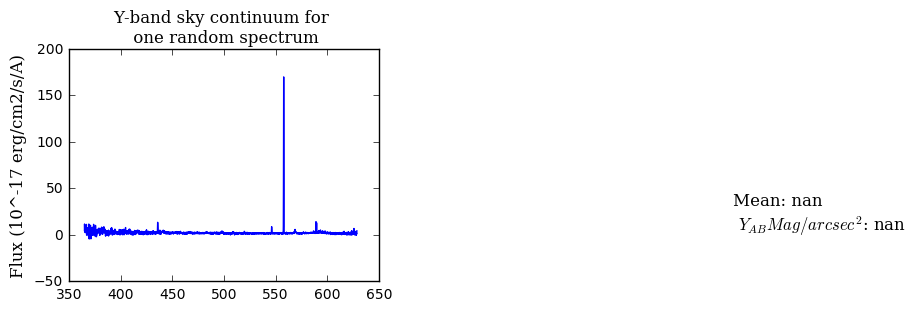

In [289]:
a = get_average(spectrum, 992.5,993.5)
b = flux_to_mag(a,Y_nm,AB_z)

plt.figure(figsize=[4,3])
plt.plot(spectrum['WAVE'], spectrum['SKY'])
#plt.xlim([992.5,993.5])
#plt.ylim([0,5])
plt.title("Y-band sky continuum for \n one random spectrum",fontproperties=font)
plt.ylabel("Flux (10^-17 erg/cm2/s/A)",fontproperties=font)
plt.text(992.8,3,"Mean: %.2f\n $Y_{AB}Mag/arcsec^{2}$: %.2f"%(a,b),fontproperties=font)


I don't have all the red split files but I can look at what I do have

In [209]:
split_dir = '/Volumes/PFagrelius_Backup/sky_data/test_data/split_flux/'
split_files = glob.glob(split_dir+"*_split_fit.npy")

Mean: 1.75 10^-17 erg/cm2/s/A
$Y_{AB}Mag/arcsec^{2}$: 20.68


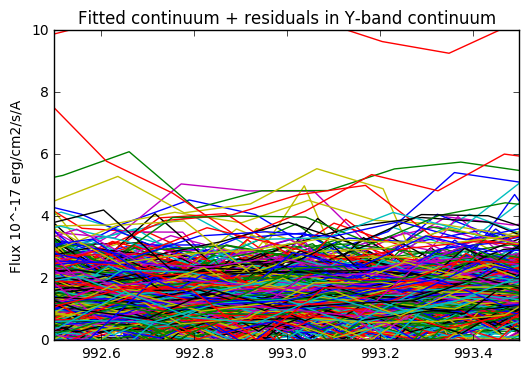

In [235]:
a = []
for file in split_files[1:4]:
    data = np.load(file)
    for i,d in enumerate(data):
        if (d['COLOR'][0] == b'r1') or (d['COLOR'][0] == b'r2'):
            plt.plot(d['WAVE'], d['CONT']+d['RESIDS'], label=i)
            a.append(get_average_cont(d, 992.5,993.5))

plt.xlim([992.5,993.5])
plt.ylim([0,10])
plt.title("Fitted continuum + residuals in Y-band continuum")
plt.ylabel("Flux 10^-17 erg/cm2/s/A")
print("Mean: %.2f 10^-17 erg/cm2/s/A" % np.mean(a))
print("$Y_{AB}Mag/arcsec^{2}$: %.2f" % flux_to_mag(np.mean(a),Y_nm,AB_z))

Now we can actually create Plot 5. . 

In [255]:
Fig_5 = []
for plate in np.unique(Red_Data['PLATE']):
    PlateData = Red_Data[Red_Data['PLATE'] == plate]
    try:
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
        for image in np.unique(PlateData['IMG']):
            ImageData = PlateData[PlateData['IMG'] == image]
            item = np.random.choice(ImageData, 1)[0]
            spectrum = data[item['SPECNO']]
            moon_alt = item['MOON_ALT']
            moon_sep = item['MOON_SEP']
            Y_band = get_average_sky(spectrum, 992.5,993.5)
            Fig_5.append([Y_band, moon_alt, moon_sep])
    except:
        print(plate)

In [256]:
Fig_5 = np.array(Fig_5)
ab_calc = flux_to_mag(Fig_5[:,0], Y_nm, AB_z)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


In [257]:
x = np.delete(ab_calc,np.where(ab_calc==np.inf))

In [258]:
np.mean(x)

21.054919849949997

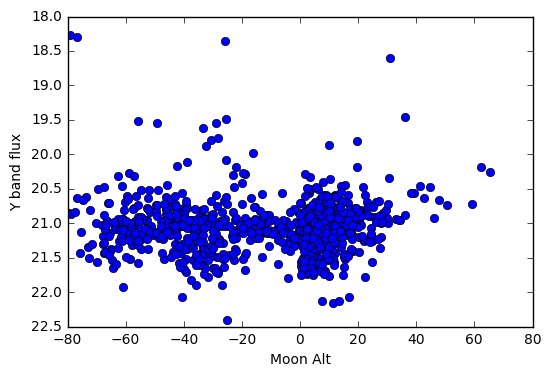

In [260]:
plt.plot(Fig_5[:,1],ab_calc,'o')
plt.xlabel('Moon Alt')
plt.ylabel('Y band flux')
plt.gca().invert_yaxis()

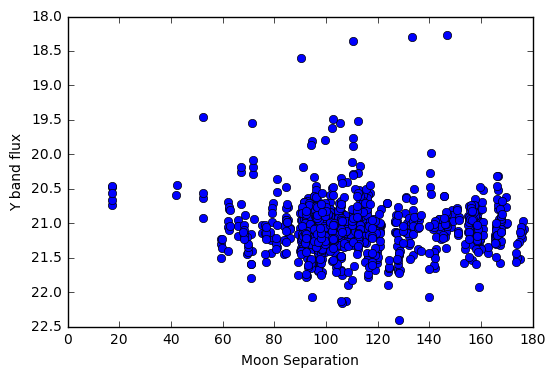

In [261]:
plt.plot(Fig_5[:,2],ab_calc,'o')
plt.xlabel('Moon Separation')
plt.ylabel('Y band flux')
plt.gca().invert_yaxis()

In conclusion, I don't see the strong correlation between the moon and the Y-band continuum. It might be because I"m not sure the whole Y-band but only a very small part. Perhaps I would also get better results if I use the actual continuum+residuals I'll eventually get from the fitting

## Neugent and Massey

This paper looks at the changes in the sky brightness over two decades and the change in bringtness when pointed at terrestrial sites. I just want to check that my spectra look similar and that the B,V values are consistent

They use Bessel filters the calculate the synthetic B and V values

In [26]:
#Get one spectrum to look at
plate = np.unique(Blue_Data['PLATE'])[20]
ThisData = Blue_Data[Blue_Data['PLATE'] == plate][0]
specno = ThisData['SPECNO']
data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
spectrum = data[specno]

### Fig. 2

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log10


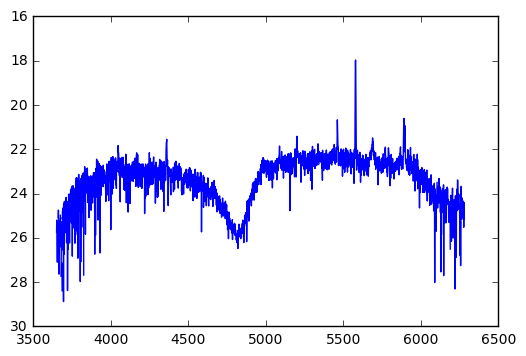

In [282]:
t1 = Trans_files['B']
t2 = Trans_files['V']
Trans1 = np.loadtxt('/Users/parkerf/Downloads/Paranal_FORS1.%s.dat'%t1)
Trans2 = np.loadtxt('/Users/parkerf/Downloads/Paranal_FORS1.%s.dat'%t2)
T1 = interpolate.interp1d(Trans1[:,0],Trans1[:,1],bounds_error=False, fill_value=0)
T2 = interpolate.interp1d(Trans2[:,0],Trans2[:,1],bounds_error=False, fill_value=0)

wave = spectrum['WAVE']*10.
spectrum['SKY'][spectrum['SKY'] == -np.inf] = 0
spectrum['SKY'][spectrum['SKY'] == np.inf] = 0

new_flux = spectrum['SKY']*10**(-17)*(wave)**2.*3.34*10**4./(np.pi)
flux1 = new_flux*T1(wave)/B_z*T1(wave)
flux2 = new_flux*T2(wave)/V_z*T2(wave)
flux_nu = flux1+flux2
mag = -2.5*np.log10(flux_nu)

plt.plot(wave, mag)
plt.gca().invert_yaxis()

The hole in the data is from teh transmission filters from ESO/Paranal. Need to get better filter funcitons for this (from Bessel 1990)

### Table 1 values

In [285]:
Table1=[]
for plate in np.unique(Blue_Data['PLATE']):
    PlateData = Blue_Data[Blue_Data['PLATE'] == plate]
    try:
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
        for image in np.unique(PlateData['IMG']):
            ImageData = PlateData[PlateData['IMG'] == image]
            item = np.random.choice(ImageData,1)[0] 
            spectrum = data[item['SPECNO']]
            B = get_Johnson_mean_mag('B',spectrum, B_z)
            V = get_Johnson_mean_mag('V',spectrum,V_z)
            Table1.append([U,B])
    except:
        print(plate)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


In [267]:
filen = Trans_files['B']
Trans = np.loadtxt('/Users/parkerf/Downloads/Paranal_FORS1.%s.dat'%filen)
T = interpolate.interp1d(Trans[:,0],Trans[:,1])

In [273]:
idx = np.where((spectrum['WAVE']*10.>Trans[0][0])&(spectrum['WAVE']*10.<Trans[-1][0]))
new_spec = spectrum[idx]
ab_spec = ab_spectrum[idx]*T(new_spec['WAVE']*10.)

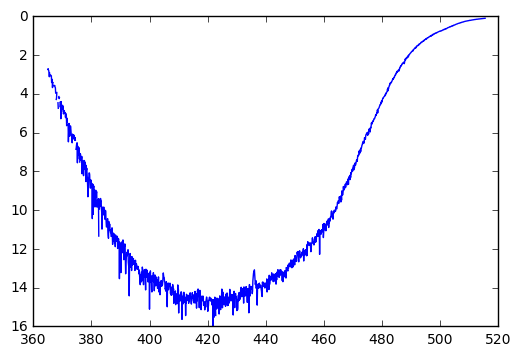

In [275]:
plt.plot(new_spec['WAVE'],ab_spec)
plt.gca().invert_yaxis()

### Narrow band results

In [15]:
# 4250
np.mean([23.00, 22.69, 22.69, 22.94, 22.95, 23.16, 22.99, 23.11])

22.941249999999997

In [32]:
mag_to_flux(22.94, 455., V_z, per_arcsec2 =True)*10/np.pi

unit: 10^-17/erg/s/cm2/A


3.510202114699595

(0, 10)

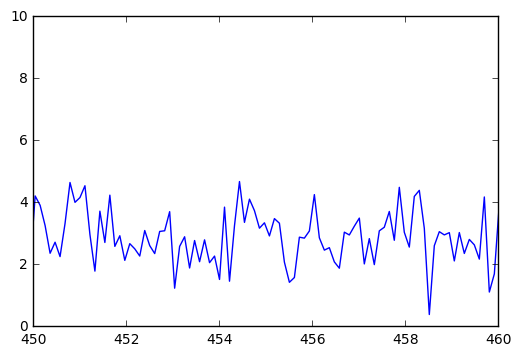

In [33]:
plt.plot(spectrum['WAVE'], spectrum['SKY'])
plt.xlim([455-5., 455+5])
plt.ylim([0,10])

## Leinert et al 1997 Plots

### Plot 10

In [72]:
#Get one spectrum to look at
plate = np.unique(Blue_Data['PLATE'])[20]
ThisData = Blue_Data[Blue_Data['PLATE'] == plate][0]
specno = ThisData['SPECNO']
data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
spectrum = data[specno]

(0, 10)

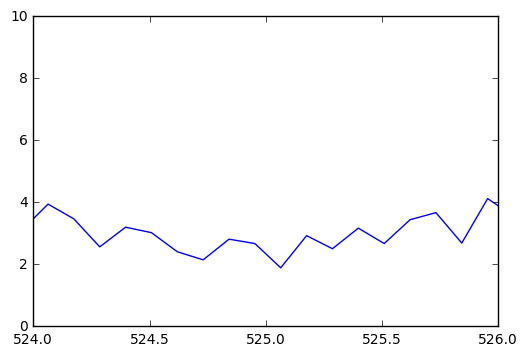

In [73]:
plt.plot(spectrum['WAVE'], spectrum['SKY'])
plt.xlim([524,526])
plt.ylim([0,10])

In [74]:
get_average(spectrum, 524, 526)

2.9642795390552945

In [75]:
Fig_10 = []
for solar in np.unique(Blue_Data['SOLARFLUX']):
    SolarData = Blue_Data[Blue_Data['SOLARFLUX'] == solar]
    specno = np.random.randint(0, len(SolarData),1)
    item = SolarData[specno[0]]
    try:
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(item['PLATE']))
        spectrum = data[item['SPECNO']]
        solar = item['SOLARFLUX']
        blue_band = get_average(spectrum, 524,526)
        Fig_10.append([blue_band, solar])
    except:
        print(plate)

In [76]:
Fig_10 = np.array(Fig_10)
solar = Fig_10[:,0]*(4.25*10**(10)/np.pi**2)*10**(-17)*10**(9) #10^-9 erg/s/cm2/sr/A

(0, 700)

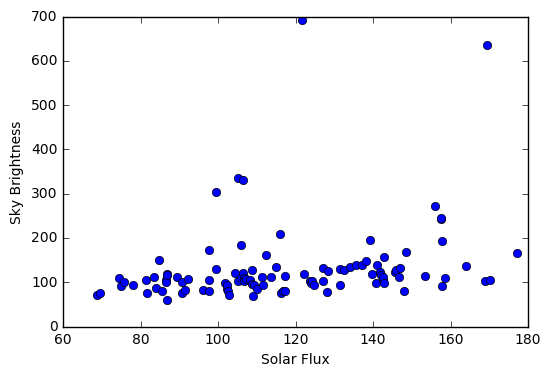

In [77]:
plt.plot(Fig_10[:,1],solar,'o')
plt.xlabel('Solar Flux')
plt.ylabel('Sky Brightness')
plt.ylim([0,700])

### Fig. 28

In [78]:
Fig_28 = []
for plate in np.unique(Blue_Data['PLATE']):
    PlateData = Blue_Data[Blue_Data['PLATE'] == plate]
    try:
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
        for image in np.unique(PlateData['IMG']):
            ImageData = PlateData[PlateData['IMG'] == image]
            specno = np.random.randint(0, len(ImageData),1)
            item = ImageData[specno[0]]
            spectrum = data[item['SPECNO']]
            lamb = get_average(spectrum, 524, 526)
            beta = get_average(spectrum, 466, 468)
            Fig_28.append([lamb, beta])
    except:
        print(plate)

In [79]:
Fig_28 = np.array(Fig_28)

In [80]:
lamb = Fig_28[:,0]*(4.25*10**(10)/np.pi**2)*10**(-17)*10**(9) #10^-9 erg/s/cm2/sr/A
beta = Fig_28[:,1]*(4.25*10**(10)/np.pi**2)*10**(-17)*10**(9) #10^-9 erg/s/cm2/sr/A

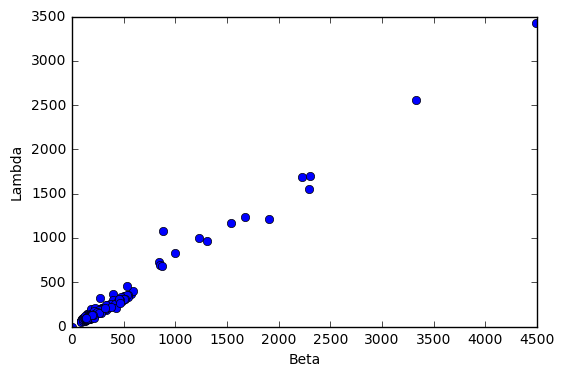

In [81]:
plt.plot(beta, lamb,'o')
plt.xlabel('Beta')
plt.ylabel('Lambda')
#plt.ylim([0,700])

## Patat 2013 Plots

Patat uses "zenith corrected average sky brigntesses during dark times"

In [11]:
DarkData = MetaData[(MetaData['AIRMASS']<1.4)&(MetaData['GAL_LAT']>10)&(np.abs(MetaData['ECL_LON']-MetaData['SUN_LON']) >= 90)&(MetaData["MOON_ALT"]<=-18)]

In [12]:
Red_Data = DarkData[(DarkData['CAMERAS'] == b'r1') | (DarkData['CAMERAS'] == b'r2')]
Blue_Data = DarkData[(DarkData['CAMERAS'] == b'b1') | (DarkData['CAMERAS'] == b'b2')]

In [13]:
#mag/arcsec^2
U = 22.35
B = 22.67
V = 21.71
R = 20.93
I = 19.65

In [14]:
U_nm = 359.62
B_nm = 424.30
V_nm = 545.74
R_nm = 647.49
I_nm = 786.46

In [15]:
U_z = 1510.2
B_z = 3856.4
V_z = 3558.2
R_z = 2939.2
I_z = 2436.4

In [16]:
mag_to_flux(V, V_nm, V_z)

7.3082275444165115

### Plot 6

In [18]:
#Get one spectrum to look at
plate = np.unique(Blue_Data['PLATE'])[20]
ThisData = Blue_Data[Blue_Data['PLATE'] == plate][0]
specno = ThisData['SPECNO']
data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
spectrum = data[specno]

In [19]:
#Get one spectrum to look at
plate = np.unique(Red_Data['PLATE'])[20]
ThisData = Red_Data[Red_Data['PLATE'] == plate][0]
specno = ThisData['SPECNO']
data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
spectrum1 = data[specno]

In [21]:
print(get_mag('U', spectrum, U_z))
print(get_mag('B', spectrum, B_z))
print(get_mag('V', spectrum, V_z))

21.6341849591
22.8688947333
22.2935809202


In [22]:
print(get_mag('R', spectrum1, R_z))
print(get_mag('I', spectrum1, I_z))

21.6766177101
20.7824563227


In [25]:
Fig_6 = []
for plate in np.unique(Blue_Data['PLATE']):
    PlateData = Blue_Data[Blue_Data['PLATE'] == plate]
    try:
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
        for image in np.unique(PlateData['IMG']):
            ImageData = PlateData[PlateData['IMG'] == image]
            specno = np.random.randint(0, len(ImageData),1)
            item = ImageData[specno[0]]
            spectrum = data[item['SPECNO']]
            solar = item['SOLARFLUX']
            U = get_mag('U', spectrum, U_z)
            B = get_mag('B',spectrum, B_z)
            V = get_mag('V',spectrum,V_z)
            Fig_6.append([U,B,V, solar])
    except:
        print(plate)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


In [73]:
Fig_6_red = []
for plate in np.unique(Red_Data['PLATE']):
    PlateData = Red_Data[Red_Data['PLATE'] == plate]
    try:
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
        for image in np.unique(PlateData['IMG']):
            ImageData = PlateData[PlateData['IMG'] == image]
            specno = np.random.randint(0, len(ImageData),1)
            item = ImageData[specno[0]]
            spectrum = data[item['SPECNO']]
            solar = item['SOLARFLUX']
            R = get_mag('R', spectrum, R_z)
            I = get_mag('I',spectrum, I_z)
            Fig_6_red.append([R,I, solar])
    except:
        print(plate)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


In [74]:
Fig_6 = np.array(Fig_6)
Fig_6_red = np.array(Fig_6_red)

In [23]:
R = np.delete(Fig_6_red[:,0], np.where(Fig_6_red[:,0]==np.inf))
I = np.delete(Fig_6_red[:,1], np.where(Fig_6_red[:,1]==np.inf))

NameError: name 'Fig_6' is not defined

In [90]:
print("U: %.2f (%.2f) " % (np.mean(Fig_6[:,0]),np.std(Fig_6[:,0])))
print("B: %.2f (%.2f)" %( np.mean(Fig_6[:,1]),np.std(Fig_6[:,1])))
print("V: %.2f (%.2f)" %( np.mean(Fig_6[:,2]),np.std(Fig_6[:,2])))
print("R: %.2f (%.2f)" %( np.mean(R),np.std(R)))
print("I: %.2f (%.2f)" %( np.mean(I),np.std(I)))

U: 21.76 (1.63) 
B: 22.62 (2.84)
V: 22.38 (0.49)
R: 21.87 (0.55)
I: 20.54 (0.00)


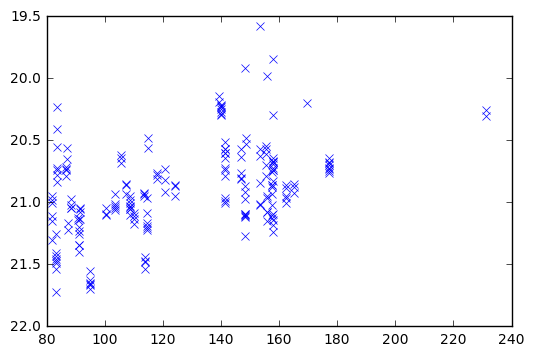

In [91]:
plt.plot(Fig_6_red[:,2],Fig_6_red[:,1],'x')
plt.gca().invert_yaxis()
#plt.ylim([23.5,22])

### Fig.9 and Fig. 10

In [101]:
#Get one spectrum to look at
plate = np.unique(Blue_Data['PLATE'])[20]
ThisData = Blue_Data[Blue_Data['PLATE'] == plate][0]
specno = ThisData['SPECNO']
data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
spectrum = data[specno]

(557.3, 558.4)

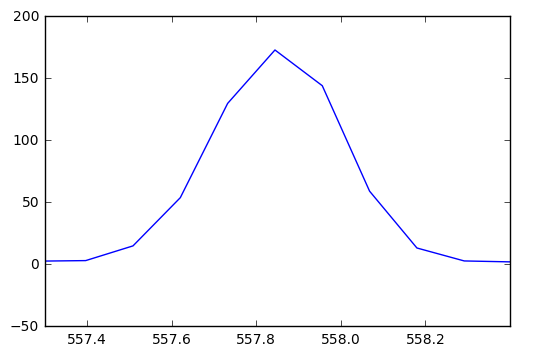

In [102]:
plt.plot(spectrum['WAVE'], spectrum['SKY'])
plt.xlim([557.3,558.4])
#plt.ylim([0,10])

In [ ]:
Fig_9 = []
for plate in np.unique(Blue_Data['PLATE']):
    PlateData = Blue_Data[Blue_Data['PLATE'] == plate]
    try:
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
        for image in np.unique(PlateData['IMG']):
            ImageData = PlateData[PlateData['IMG'] == image]
            specno = np.random.randint(0, len(ImageData),1)
            item = ImageData[specno[0]]
            spectrum = data[item['SPECNO']]
            solar = item['SOLARFLUX']
            flux = get_average(spectrum, 557.3,558.4)/(np.pi**2.)
            print(flux)
            Fig_9.append([np.log10(flux), solar])
    except:
        print(plate)

3666
3689
3754
3770
3983


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4018)
KeyboardInterrupt


4456
4460
4482
4504
4507
4628
4644
4655
4740
4796
4832
5162
5169
5326
5332
5339
5380
5419
5786
5892
5989
5996
6429
6668
6717
6986
7083
7091
7098
7108


In [205]:
Fig_9 = np.array(Fig_9)

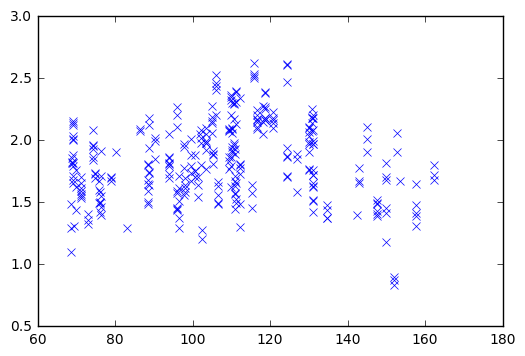

In [207]:
plt.plot(Fig_9[:,1], Fig_9[:,0],'x')